# CCGANs - Context-Conditional Generative Adversarial Networks

Brief introduction to Context-Conditional Generative Adversarial Networks or CCGANs. This notebook is organized as follows:

1. **Research Paper**
* **Background**
* **Definition**
* **Training CCGANs with MNIST dataset, Keras and TensorFlow**


## 1. Research Paper

* [Semi-Supervised Learning with Context-Conditional Generative Adversarial Networks](https://arxiv.org/pdf/1611.06430.pdf)

## 2. Background

**Generative adversarial nets** consists of two models: a generative model $G$ that captures the data distribution, and a discriminative model $D$ that estimates the probability that a sample came from the training data rather than $G$.

The generator distribution $p_g$ over data data $x$, the generator builds a mapping function from a prior noise distribution $p_z(z)$ to data space as $G(z;\theta_g)$.

The discriminator, $D(x;\theta_d)$, outputs a single scalar representing the probability that $x$ came form training data rather than $p_g$.

The value function $V(G,D)$:

$$ \underset{G}{min} \: \underset{D}{max} \; V_{GAN}(D,G) = \mathbb{E}_{x\sim p_{data}(x)}[log D(x)] + \mathbb{E}_{z\sim p_{z}(z)}[log(1 - D(G(z)))]$$


## 3. Definition

Context-Conditional Generative Adversarial Networks (CC-GANs) are conditional GANs where the generator is trained to fill in a missing image patch and the generator and discriminator are conditioned on the surrounding pixels.

CC-GANs address a different task: determining if a part of an image is real or fake given the surrounding context.

The generator $G$ receives as input an image with a randomly masked out patch. The generator outputs an entire image.  We fill in the missing patch from the generated output and then pass the completed image into $D$.

### Network Design

<img src="../../img/network_design_cc_gan.png" width="600"> 


### Cost Funcion

$$
\begin{aligned}
    \underset{G}{min} \: \underset{D}{max} \; V_{CCGAN}(D,G) =& \mathbb{E}_{x\sim \mathcal{X}}[log D(x)] + \mathbb{E}_{x\sim \mathcal{X}, m\sim \mathcal{M}}[log(1 - D(x_I))] \\
    x_I =& (1 - m) \bigodot x_G + m \bigodot x \\
    x_G =& G(m \bigodot x, z)
\end{aligned}
$$

## 3. Training CCGANs with MINIST dataset, Keras and TensorFlow

CCGANs implementation using "U-net" model and convolutional neural network and the [Keras](https://keras.io/) library.

* **Data**
    * Rescale the MNIST images to be between -1 and 1.
    * Resize 32x32
    
* **Generator**
    * **U-net network**.
    * The input to the generator is the **normal distribution** $z$.
    * The last activation is **tanh**.
    
* **Discriminator**
    * **Convolutional neural network** and **LeakyReLU activation**.
    * The last activation is **softmax**.
    
* **Loss**
    * Discriminator: loss=['mse', 'categorical_crossentropy'].
    * Adversarial: loss=['mse']

* **Optimizer**
    * Adam(lr=0.0002, beta_1=0.5)

* batch_size = 64
* epochs = 100

### 1. Load data

#### Load libraries

In [1]:
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
from keras.datasets import mnist
from keras.models import Sequential, Model
from keras.layers import Dense, LeakyReLU, BatchNormalization
from keras.layers import Input, Flatten, Embedding, multiply, Dropout
from keras.optimizers import Adam
from keras import initializers

from keras_contrib.layers.normalization import InstanceNormalization
from keras.layers import Concatenate, GaussianNoise
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras import losses
from keras.utils import to_categorical
import keras.backend as K

# from scipy.misc import imresize
from skimage.transform import resize

Using TensorFlow backend.


#### Getting the data

In [3]:
# load dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()

#### Explore visual data

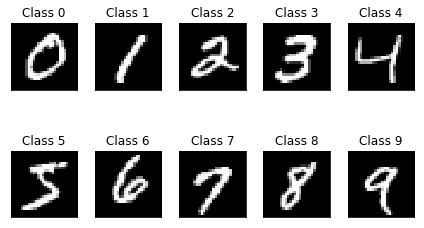

In [4]:
fig = plt.figure()
for i in range(10):
    plt.subplot(2, 5, i+1)
    x_y = X_train[y_train == i]
    plt.imshow(x_y[0], cmap='gray', interpolation='none')
    plt.title("Class %d" % (i))
    plt.xticks([])
    plt.yticks([])
    
plt.tight_layout()

#### Reshaping and normalizing the inputs

In [5]:
print('X_train.shape', X_train.shape)
print('y_train.shape', y_train.shape)

if K.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 1, 28, 28)
    X_test = X_test.reshape(X_test.shape[0], 1, 28, 28)
    input_shape = (1, 28, 28)
else:
    X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
    X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)
    input_shape = (28, 28, 1)

# the generator is using tanh activation, for which we need to preprocess 
# the image data into the range between -1 and 1.

X_train = np.float32(X_train)
X_train = (X_train / 255 - 0.5) * 2
X_train = np.clip(X_train, -1, 1)

# y to categorical
num_classes = 10
y_train = to_categorical(y_train, num_classes=num_classes+1)

print('X_train reshape:', X_train.shape)
print('y_train reshape:', y_train.shape)

X_train.shape (60000, 28, 28)
y_train.shape (60000,)
X_train reshape: (60000, 28, 28, 1)
y_train reshape: (60000, 11)


In [6]:
X_train = resize(X_train, [X_train.shape[0], 32, 32, 1])
print('X_train reshape:', X_train.shape)

/home/ariza/.conda/envs/generative/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ariza/.conda/envs/generative/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


X_train reshape: (60000, 32, 32, 1)


### 2. Define model

#### Generator

In [7]:
# Number of filters in first layer of generator
gf = 32
k = 4
s = 2

# imagem shape 28x28x1
img_shape = X_train[0].shape

# Generator input
img_g = Input(shape=(img_shape))

# Downsampling
d1 = Conv2D(gf, kernel_size=k, strides=s, padding='same')(img_g)
d1 = LeakyReLU(alpha=0.2)(d1)

d2 = Conv2D(gf*2, kernel_size=k, strides=s, padding='same')(d1)
d2 = LeakyReLU(alpha=0.2)(d2)
d2 = BatchNormalization(momentum=0.8)(d2)

d3 = Conv2D(gf*4, kernel_size=k, strides=s, padding='same')(d2)
d3 = LeakyReLU(alpha=0.2)(d3)
d3 = BatchNormalization(momentum=0.8)(d3)

d4 = Conv2D(gf*8, kernel_size=k, strides=s, padding='same')(d3)
d4 = LeakyReLU(alpha=0.2)(d4)
d4 = BatchNormalization(momentum=0.8)(d4)

# Upsampling
u1 = UpSampling2D(size=2)(d4)
u1 = Conv2D(gf*4, kernel_size=k, strides=1, padding='same', activation='relu')(u1)
u1 = BatchNormalization(momentum=0.8)(u1)

u2 = Concatenate()([u1, d3])
u2 = UpSampling2D(size=2)(u2)
u2 = Conv2D(gf*2, kernel_size=k, strides=1, padding='same', activation='relu')(u2)
u2 = BatchNormalization(momentum=0.8)(u2)

u3 = Concatenate()([u2, d2])
u3 = UpSampling2D(size=2)(u3)
u3 = Conv2D(gf, kernel_size=k, strides=1, padding='same', activation='relu')(u3)
u3 = BatchNormalization(momentum=0.8)(u3)

u4 = Concatenate()([u3, d1])
u4 = UpSampling2D(size=2)(u4)
u4 = Conv2D(1, kernel_size=4, strides=1, padding='same', activation='tanh')(u4)

generator = Model(img_g, u4)

#### Generator model visualization

In [8]:
# prints a summary representation of your model
generator.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 16, 16, 32)   544         input_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 16, 16, 32)   0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 8, 8, 64)     32832       leaky_re_lu_1[0][0]              
__________________________________________________________________________________________________
leaky_re_l

#### Discriminator

In [9]:
# Discriminator network
k = 4

discriminator = Sequential()
discriminator.add(Conv2D(64, kernel_size=k, strides=2, padding='same', input_shape=img_shape))
discriminator.add(LeakyReLU(alpha=0.8))
discriminator.add(Conv2D(128, kernel_size=k, strides=2, padding='same'))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(InstanceNormalization())
discriminator.add(Conv2D(256, kernel_size=k, strides=2, padding='same'))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(InstanceNormalization())

img_d = Input(shape=img_shape)
features = discriminator(img_d)

validity = Conv2D(1, kernel_size=k, strides=1, padding='same')(features)
# validity = Flatten()(validity)
# validity = Dense(1, activation='sigmoid')(validity)

label = Flatten()(features)
label = Dense(num_classes+1, activation="softmax")(label)

discriminator = Model(img_d, [validity, label])

#### Discriminator model visualization

In [10]:
# prints a summary representation of your model
discriminator.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 32, 32, 1)    0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 4, 4, 256)    656836      input_2[0][0]                    
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 4096)         0           sequential_1[1][0]               
__________________________________________________________________________________________________
conv2d_12 (Conv2D)              (None, 4, 4, 1)      4097        sequential_1[1][0]               
__________________________________________________________________________________________________
dense_1 (D

### 3. Compile model

#### Compile discriminator

In [11]:
# Optimizer
optimizer = Adam(lr=0.0002, beta_1=0.5)

discriminator.compile(optimizer=optimizer, loss=['mse', 'categorical_crossentropy'],
                      loss_weights=[0.5, 0.5], metrics=['accuracy'])

#### Combined network

In [12]:
# The generator takes noise as input and generates imgs
masked_img = Input(shape=(img_shape))
gen_img = generator(masked_img)

# For the combined model we will only train the generator
discriminator.trainable = False

validity, _ = discriminator(gen_img)

d_g = Model(masked_img, validity)

d_g.compile(optimizer=optimizer, loss='mse', metrics=['accuracy'])

In [13]:
# prints a summary representation of your model
d_g.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 32, 32, 1)         0         
_________________________________________________________________
model_1 (Model)              (None, 32, 32, 1)         1545025   
_________________________________________________________________
model_2 (Model)              [(None, 4, 4, 1), (None,  706000    
Total params: 2,251,025
Trainable params: 1,543,681
Non-trainable params: 707,344
_________________________________________________________________


In [14]:
def mask_randomly(imgs, mask_width=10, mask_height=10):
    y1 = np.random.randint(0, imgs.shape[1] - mask_height, imgs.shape[0])
    y2 = y1 + mask_height
    x1 = np.random.randint(0, imgs.shape[2] - mask_width, imgs.shape[0])
    x2 = x1 + mask_width

    masked_imgs = np.empty_like(imgs)
    for i, img in enumerate(imgs):
        masked_img = img.copy()
        _y1, _y2, _x1, _x2 = y1[i], y2[i], x1[i], x2[i],
        masked_img[_y1:_y2, _x1:_x2, :] = 0
        masked_imgs[i] = masked_img

    return masked_imgs

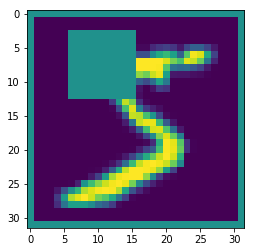

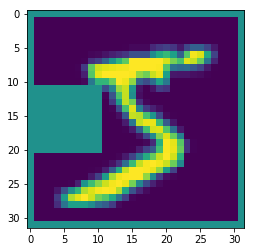

In [15]:
plt.imshow(mask_randomly(X_train[0:1])[0].reshape(32, 32))
plt.show()
plt.imshow(mask_randomly(X_train[0:1])[0].reshape(32, 32))
plt.show()

### 4. Fit model


epoch = 1/100, d_loss=0.419, g_loss=0.205                                                                                                                      


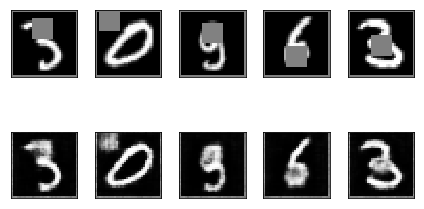

epoch = 2/100, d_loss=0.224, g_loss=0.312                                                                                                                      
epoch = 3/100, d_loss=0.521, g_loss=0.180                                                                                                                       
epoch = 4/100, d_loss=0.346, g_loss=0.207                                                                                                                      
epoch = 5/100, d_loss=0.680, g_loss=0.190                                                                                                                      
epoch = 6/100, d_loss=0.280, g_loss=0.263                                                                                                                      
epoch = 7/100, d_loss=0.102, g_loss=0.109                                                                                                                      
epoch = 8/100, d_loss=0.773, g_loss=0.2

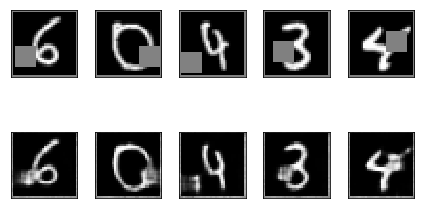

epoch = 12/100, d_loss=0.087, g_loss=0.126                                                                                                                      
epoch = 13/100, d_loss=0.073, g_loss=0.098                                                                                                                      
epoch = 14/100, d_loss=0.079, g_loss=0.086                                                                                                                      
epoch = 15/100, d_loss=0.069, g_loss=0.108                                                                                                                      
epoch = 16/100, d_loss=0.077, g_loss=0.101                                                                                                                      
epoch = 17/100, d_loss=0.069, g_loss=0.110                                                                                                                      
epoch = 18/100, d_loss=0.071, g_lo

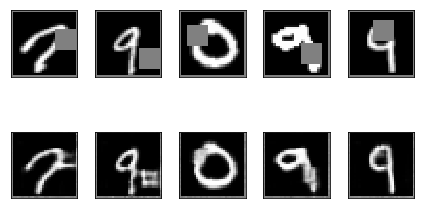

epoch = 22/100, d_loss=0.067, g_loss=0.099                                                                                                                      
epoch = 23/100, d_loss=0.067, g_loss=0.123                                                                                                                      
epoch = 24/100, d_loss=0.068, g_loss=0.134                                                                                                                      
epoch = 25/100, d_loss=0.067, g_loss=0.115                                                                                                                      
epoch = 26/100, d_loss=0.076, g_loss=0.169                                                                                                                      
epoch = 27/100, d_loss=0.067, g_loss=0.087                                                                                                                      
epoch = 28/100, d_loss=0.068, g_lo

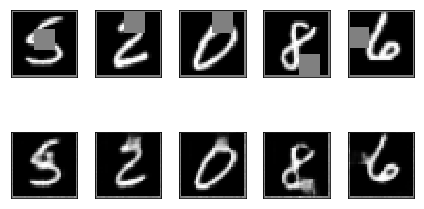

epoch = 32/100, d_loss=0.066, g_loss=0.106                                                                                                                      
epoch = 33/100, d_loss=0.066, g_loss=0.136                                                                                                                      
epoch = 34/100, d_loss=0.101, g_loss=0.099                                                                                                                      
epoch = 35/100, d_loss=0.066, g_loss=0.136                                                                                                                      
epoch = 36/100, d_loss=0.066, g_loss=0.150                                                                                                                      
epoch = 37/100, d_loss=0.066, g_loss=0.151                                                                                                                      
epoch = 38/100, d_loss=0.068, g_lo

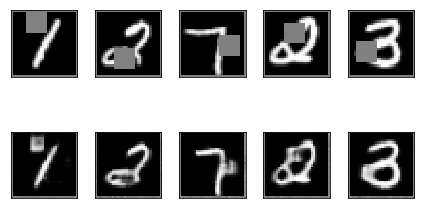

epoch = 42/100, d_loss=0.066, g_loss=0.117                                                                                                                      
epoch = 43/100, d_loss=0.066, g_loss=0.099                                                                                                                      
epoch = 44/100, d_loss=0.066, g_loss=0.101                                                                                                                      
epoch = 45/100, d_loss=0.067, g_loss=0.083                                                                                                                      
epoch = 46/100, d_loss=0.065, g_loss=0.121                                                                                                                      
epoch = 47/100, d_loss=0.067, g_loss=0.077                                                                                                                      
epoch = 48/100, d_loss=0.065, g_lo

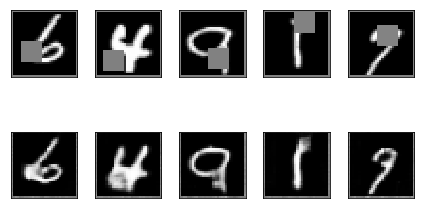

epoch = 52/100, d_loss=0.065, g_loss=0.107                                                                                                                      
epoch = 53/100, d_loss=0.362, g_loss=0.265                                                                                                                      
epoch = 54/100, d_loss=0.064, g_loss=0.124                                                                                                                      
epoch = 55/100, d_loss=0.066, g_loss=0.082                                                                                                                      
epoch = 56/100, d_loss=0.064, g_loss=0.162                                                                                                                      
epoch = 57/100, d_loss=0.065, g_loss=0.142                                                                                                                      
epoch = 58/100, d_loss=0.066, g_lo

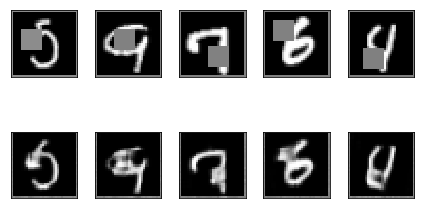

epoch = 62/100, d_loss=0.064, g_loss=0.095                                                                                                                      
epoch = 63/100, d_loss=0.065, g_loss=0.097                                                                                                                      
epoch = 64/100, d_loss=0.064, g_loss=0.104                                                                                                                      
epoch = 65/100, d_loss=0.065, g_loss=0.097                                                                                                                      
epoch = 66/100, d_loss=0.065, g_loss=0.099                                                                                                                      
epoch = 67/100, d_loss=0.064, g_loss=0.117                                                                                                                      
epoch = 68/100, d_loss=0.065, g_lo

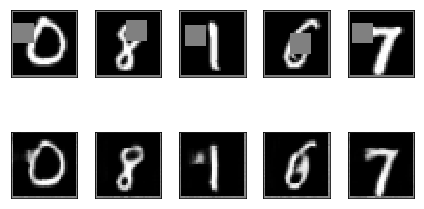

epoch = 72/100, d_loss=0.064, g_loss=0.086                                                                                                                      
epoch = 73/100, d_loss=0.065, g_loss=0.061                                                                                                                      
epoch = 74/100, d_loss=0.064, g_loss=0.106                                                                                                                      
epoch = 75/100, d_loss=0.064, g_loss=0.125                                                                                                                      
epoch = 76/100, d_loss=0.067, g_loss=0.130                                                                                                                      
epoch = 77/100, d_loss=0.064, g_loss=0.129                                                                                                                      
epoch = 78/100, d_loss=0.065, g_lo

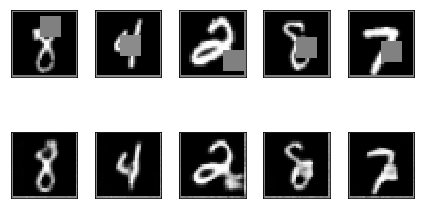

epoch = 82/100, d_loss=0.064, g_loss=0.088                                                                                                                      
epoch = 83/100, d_loss=0.064, g_loss=0.199                                                                                                                      
epoch = 84/100, d_loss=0.064, g_loss=0.188                                                                                                                      
epoch = 85/100, d_loss=0.064, g_loss=0.109                                                                                                                      
epoch = 86/100, d_loss=0.064, g_loss=0.083                                                                                                                      
epoch = 87/100, d_loss=0.070, g_loss=0.079                                                                                                                      
epoch = 88/100, d_loss=0.064, g_lo

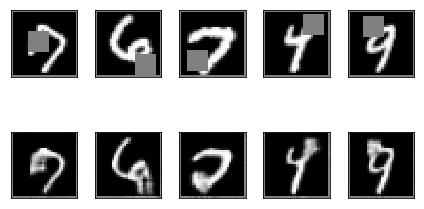

epoch = 92/100, d_loss=0.064, g_loss=0.066                                                                                                                      
epoch = 93/100, d_loss=0.064, g_loss=0.096                                                                                                                      
epoch = 94/100, d_loss=0.064, g_loss=0.143                                                                                                                      
epoch = 95/100, d_loss=0.064, g_loss=0.206                                                                                                                      
epoch = 96/100, d_loss=0.064, g_loss=0.198                                                                                                                      
epoch = 97/100, d_loss=0.066, g_loss=0.066                                                                                                                      
epoch = 98/100, d_loss=0.064, g_lo

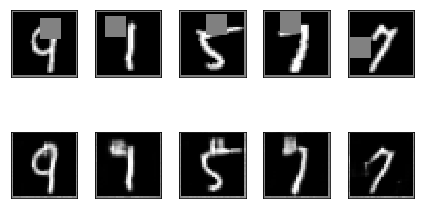

In [16]:
epochs = 100
batch_size = 64
smooth = 0.1

real = np.ones((batch_size, 4, 4, 1))
real = real * (1 - smooth)
fake = np.zeros((batch_size, 4, 4, 1))

fake_labels = to_categorical(np.full((batch_size, 1), num_classes), num_classes=num_classes+1)

d_loss = []
d_g_loss = []

for e in range(epochs + 1):
    for i in range(len(X_train) // batch_size):
        
        # Train Discriminator weights
        discriminator.trainable = True
        
        # Real samples
        img_real = X_train[i*batch_size:(i+1)*batch_size]
        real_labels = y_train[i*batch_size:(i+1)*batch_size]
        
        d_loss_real = discriminator.train_on_batch(x=img_real, y=[real, real_labels])
        
        # Fake Samples
        masked_imgs = mask_randomly(img_real)
        gen_imgs = generator.predict(masked_imgs)
        
        d_loss_fake = discriminator.train_on_batch(x=gen_imgs, y=[fake, fake_labels])
         
        # Discriminator loss
        d_loss_batch = 0.5 * (d_loss_real[0] + d_loss_fake[0])
        
        # Train Generator weights
        discriminator.trainable = False

        d_g_loss_batch = d_g.train_on_batch(x=img_real, y=real)
   
        print(
            'epoch = %d/%d, batch = %d/%d, d_loss=%.3f, g_loss=%.3f' % (e + 1, epochs, i, len(X_train) // batch_size, d_loss_batch, d_g_loss_batch[0]),
            100*' ',
            end='\r'
        )
    
    d_loss.append(d_loss_batch)
    d_g_loss.append(d_g_loss_batch[0])
    print('epoch = %d/%d, d_loss=%.3f, g_loss=%.3f' % (e + 1, epochs, d_loss[-1], d_g_loss[-1]), 100*' ')

    if e % 10 == 0:
        samples = 5
        idx = np.random.randint(0, X_train.shape[0], samples)
        masked_imgs = mask_randomly(X_train[idx])
        x_fake = generator.predict(masked_imgs)

        for k in range(samples):
            # plot masked
            plt.subplot(2, 5, k+1)
            plt.imshow(masked_imgs[k].reshape(32, 32), cmap='gray')
            plt.xticks([])
            plt.yticks([])

            # plot recontructed
            plt.subplot(2, 5, k+6)
            plt.imshow(x_fake[k].reshape(32, 32), cmap='gray')
            plt.xticks([])
            plt.yticks([])

        plt.tight_layout()
        plt.show()

### 5. Evaluate model

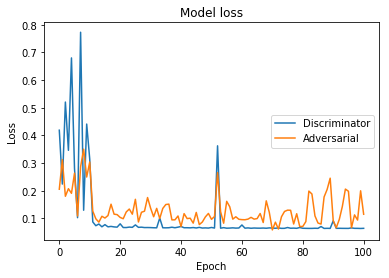

In [17]:
# plotting the metrics
plt.plot(d_loss)
plt.plot(d_g_loss)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Discriminator', 'Adversarial'], loc='center right')
plt.show()